In [1]:
#importing all the various libraries

from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Like the saying goes: good developers copy code, great developers paste; we are not going to be writing all codes from the ground up. My approach here is to refactor code and give credit where due to fasten development.

First is HTML parsing code by Eustache Diemert. The code was very well layed out and efficient compared with all other code snippet i found online. Scikit-learn gave his contribution a thumbs up, so i figured i settle. This code basically downloads the files from the URL, unzips it and rebuilds the SGML files into a one file. One can also download the zip file and do the same.

In [2]:
# Credit goes to Eustache Diemert <eustache@diemert.fr>
# @FedericoV <https://github.com/FedericoV/>
# @https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html
# License: BSD 3 clause
# 

class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        self.attributes = dict(attributes) # Attributes is a list of pairs
        #pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics,
                         'new_id': self.attributes["newid"],})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('https://drive.google.com/drive/folders/1k7MNpw_huZTL9opXU9e7u6M8phupPih7')
    ARCHIVE_FILENAME = 'reuters21578-20211018T220355Z-001.zip'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write('\r')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc           

**GLIMPSE INTO THE DATASET**

In [3]:
#printing the first 5 documents

full_list = list(stream_reuters_documents())
full_list[:4]

[{'title': 'BAHIA COCOA REVIEW',
  'body': 'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this co

In [4]:
#total number of documents in all files
len(full_list)

21578

In [5]:
#merging the body and topics elements in the documents
data_labels = [(x['body'], x['topics']) for x in list(stream_reuters_documents())]

In [6]:
#checking for empty topic lists
[w for w in data_labels if w[1] == []][:7]

[('', []),
 ('', []),
 ('', []),
 ('', []),
 ('', []),
 ('<Pacific Western Airlines Corp> said it integrated the senior management of Pacific Western and recently acquired Canadian Pacific Air Lines Ltd in preparation for the companies\' merger this summer. Pacific Western said it appointed president and chief executive Rhys Eaton as chairman and chief executive in the new management structure, and Murray Sigler as president. Sigler was previously president of Pacific Western\'s airline unit, Pacific Western Airlines Ltd. Pacific Western acquired Canadian Pacific Air Lines for 300 mln dlrs last December from Canadian Pacific Ltd <CP>. Canadian Pacific Air Lines said president and chief executive Donald Carty and four senior vice-presidents resigned last week. Carty said in a company memorandum that he accepted another senior post in commercial aviation and that some of the vice-presidents were taking early retirment and others were resigning for personal reasons. Pacific Western said t

In [7]:
#quick statistics of number of documents 
new_full_list = [b for b in full_list if not b['body'] == '' and not b['topics'] == []]
unseen_list = [b for b in full_list if not b['body'] == '' and b['topics'] == []]
empty_body_topic = [x for x in full_list if x['body'] == '' and x['topics'] == []]

print('total # of documents in the 20 sgml files:', len(full_list),)
print('# of documents with no missing body & topic values:', len(new_full_list),)
print('# of documents with missing topic values:', len(unseen_list),)
print('# of documents with both body & topics values missing:', len(empty_body_topic),)
print('# of documents that are all null:', len(full_list) - (len(new_full_list) + len(unseen_list) + len(empty_body_topic)))

total # of documents in the 20 sgml files: 21578
# of documents with no missing body & topic values: 18457
# of documents with missing topic values: 586
# of documents with both body & topics values missing: 1276
# of documents that are all null: 1259


Since this a supervised learning model, we are going to be doing the following: 
- We are going to be getting the train and test sets from the documents with no missing body & topic values above
- Deleting the documents that are all null (i.e., has nothing in the documents)
- Deleting the documents that have items in them, but missing the body and topics values. In a way this is questionable, and should be revisted if the overall performance of the model is subpar. It will be interesting to see the effect of filling the data & topics with nulls or some arbitrary string values would have on the overasll model performance
- Last, we use the documents with the missing topics to do final prediction after the analysis. We can also add the examples back into the training set after prediction and then run another training on the concatenated training set much like semi-supervised learning to see if this improves the model.

In [8]:
#split the body and topics into features and labels respectively
labels = [x['topics'] for x in new_full_list]
data = [x['body'] for x in new_full_list]

In [9]:
#what the data in a document looks like
data[0]

'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are

In [10]:
#what the lablels for first document looks like
labels[0]

['cocoa', 'el-salvador', 'usa', 'uruguay']

**SPLITTING THE DATASET INTO TRAIN & TEST SETS**

Now is the time to split the data into train and test sets to prevent data leakage and snopping. I am using an arbitrary split of 80/20, i.e., 80% of the dataset will be in the training set and 20% of the data will be in the test set. This split can actually be a custom hyperparamter one can tune on the dataset to know what proportion of split gets the max performance on the model. However, leaving this as arbitrary for now. 

In [11]:
#splitting the data into the training and the test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

NOTE: I would have loved to use the stratified split on this analysis, but for reasons I will mention later. 

In [12]:
len(X_train), len(y_train)

(14765, 14765)

In [13]:
X_train[0]

'First Southern Federal Savings and Loan Association said it has agreed in principle to acquire Horizon Financial Corp and Horizon Funding corp from <Victor Federal Savings and Loan Association> of Muskogee, Okla., for undisclosed terms. The company said the purchase is subject to approval of the boards of First Southern and Victor and regulatory agencies. Horizon Financial services mortgage loans and Horizon Funding is a wholesale loan purchasing operation. Horizon services 3.2 billion dlrs in mortgage loans. Reuter '

**CLEANING OF THE BODY OF THE DOCUMENTS**

For cleaning of the data, we are using snippet from Irfan Alghani Khalid as is with a little refactoring 

In [14]:
import nltk
import string
from nltk.corpus import stopwords

stop_words = stopwords.words("english")


def text_preproc(x):
    """
    credit goes to Irfan Alghani Khalid 
    @https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76
    """
   
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

In [15]:
X_train = [text_preproc(x) for x in X_train]
X_test = [text_preproc(x) for x in X_test]

In [16]:
X_train[0]

'first southern federal savings loan association said agreed principle acquire horizon financial corp horizon funding corp victor federal savings loan association muskogee okla undisclosed terms company said purchase subject approval boards first southern victor regulatory agencies horizon financial services mortgage loans horizon funding wholesale loan purchasing operation horizon services billion dlrs mortgage loans reuter '

In [17]:
y_train[:7]

[['acq', 'usa'],
 ['sugar', 'mauritius', 'uk'],
 ['acq', 'usa'],
 ['usa'],
 ['usa'],
 ['usa'],
 ['grain', 'orange', 'sugar', 'china']]

In [18]:
len(y_train)

14765

**PREPROCESSING OF THE FEATURES AND MULTILABELS**

In [19]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
stop_words = stopwords.words("english")

#tokenization
#vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18, alternate_sign=False)
vectorizer = TfidfVectorizer(stop_words=stop_words,)

#learn & transform
vectorized_train_docu = vectorizer.fit_transform(X_train)
vectorized_test_docu = vectorizer.transform(X_test)

#transform multilabel labels
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

**PREDICTION AND EVALUATION**

In [20]:
#initialize classifer
classifier=OneVsRestClassifier(LinearSVC(random_state=42, class_weight='balanced'))

In [21]:
#fitting the classier to the data
classifier = classifier.fit(vectorized_train_docu, train_labels)
classifier

OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced',
                                        random_state=42))

In [22]:
#fitting the classier to the data
#classifier = classifier.fit(vectorized_train_docu, train_labels)

#prediction
predictions = classifier.predict(vectorized_test_docu)

#converting predictions back to actual labels
all_labels = mlb.inverse_transform(predictions)
#all_labels

In [23]:
def pred_eval(classifier, train_data, training_label, test_data, test_labels):
    from sklearn.model_selection import KFold, cross_val_score
    
    kf = KFold(n_splits=5, random_state = 42, shuffle = True)
    scores = cross_val_score(classifier, train_data, training_label, cv = kf)
    print('Cross-validation scores:', scores)
    print('Cross-validation accuracy: {:.4f} (+/- {:.4f})\n'.format(scores.mean(), scores.std() * 2),)
    
    predictions = classifier.predict(test_data)

    precision = precision_score(test_labels, predictions, average='micro')
    recall = recall_score(test_labels, predictions, average='micro')
    f1 = f1_score(test_labels, predictions, average='micro')
 
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}\n".format(precision, recall, f1))
 
    precision = precision_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    f1 = f1_score(test_labels, predictions, average='macro')
 
    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}" .format(precision, recall, f1))
    

In [24]:
pred_eval(classifier, vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

Cross-validation scores: [0.61835422 0.61429055 0.61056553 0.61361327 0.59295632]
Cross-validation accuracy: 0.6100 (+/- 0.0177)

Micro-average quality numbers
Precision: 0.8638, Recall: 0.8504, F1-measure: 0.8571

Macro-average quality numbers
Precision: 0.4723, Recall: 0.4040, F1-measure: 0.4235


This is a benchmark we will be working with. Few questions we need to address are:
 - Can we do better than these benchmarks?
 - Why did this model underperform?
 - How can we improve this?

**Can we do better than these benchmarks?**

Of course yes! The accuracy is barely close to a coin toss, which is somewhat evidenced by averaging the F1-score of both the Micro and Macro average statistics

The accuracy score metric is not a good indicator in this analysis because the labels are greatly imbalanced. The model in some way will be biased toward the majority labels and classes. This can be evidenced from the statistics from the Micro-average quality numbers and the Macro-average quality numbers of the precision, recall and F1-scores. Those interested can read more about those statistics @: 
- https://stats.stackexchange.com/questions/156923/should-i-make-decisions-based-on-micro-averaged-or-macro-averaged-evaluation-mea and 
- https://stats.stackexchange.com/questions/156923/should-i-make-decisions-based-on-micro-averaged-or-macro-averaged-evaluation-mea

General consensus is that for multiclass classification, the Micro-average quality numbers is preferable. However, for a multilabel classification, which is what we are implementing in this analysis, both of the metrics should be about same or comparable to achieve good predictive analysis


**Why did this model underperform?**

Let us run a few exploratory data analysis on the data to see the patterns

In [25]:
import itertools
merged_labels = list(itertools.chain(*labels)) #flattening list of list

In [26]:
#creating a dataframe sorted by the number of counts of each labels in the documents
import collections
counter=collections.Counter(merged_labels)
df = pd.DataFrame(zip(counter.keys(), counter.values()), columns = ['labels', 'counts'])
df2 = df2 = df.sort_values(by='counts', ascending=False)
df2.head(15)

,labels,counts
2,usa,12322
20,earn,3776
21,acq,2210
29,uk,1451
64,japan,1104
27,canada,1063
69,money-fx,684
5,grain,574
52,crude,566
113,west-germany,558


In [27]:
len(df2)

444

In [28]:
counter.keys()

dict_keys(['cocoa', 'el-salvador', 'usa', 'uruguay', 'brazil', 'grain', 'wheat', 'corn', 'barley', 'oat', 'sorghum', 'veg-oil', 'linseed', 'lin-oil', 'soy-oil', 'sun-oil', 'soybean', 'oilseed', 'sunseed', 'argentina', 'earn', 'acq', 'yemen-arab-republic', 'copper', 'venezuela', 'reagan', 'housing', 'canada', 'coffee', 'uk', 'ico-coffee', 'iran', 'ship', 'sugar', 'trade', 'reserves', 'new-zealand', 'panama', 'honduras', 'money-supply', 'wilson', 'meal-feed', 'soy-meal', 'maxwell', 'philippines', 'rye', 'cotton', 'iraq', 'carcass', 'livestock', 'china', 'nyse', 'crude', 'opec', 'nat-gas', 'algeria', 'cpi', 'gnp', 'switzerland', 'oecd', 'ussr', 'lyng', 'volcker', 'south-korea', 'japan', 'france', 'chirac', 'italy', 'russell', 'money-fx', 'interest', 'hong-kong', 'taiwan', 'bop', 'australia', 'keating', 'rice', 'thailand', 'red-bean', 'ongpin', 'colombia', 'rubber', 'copra-cake', 'palm-oil', 'palmkernel', 'tea', 'plywood', 'indonesia', 'kuwait', 'ecuador', 'worldbank', 'india', 'gandhi', '

In [29]:
df2.tail(15)

,labels,counts
398,steeg,1
397,lin-meal,1
395,dkr,1
393,skr,1
392,vanuatu,1
391,mauritania,1
390,young,1
268,imco,1
386,set,1
383,ryzhkov,1


NOTE: The DataFrame above shows why a stratified split would not work as mentioned earlier. This is because the least populated class in labels has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [30]:
#function to plot the counts of the occurrences of the labels
def df_occr(dataframe, limit=None):
    df = dataframe.head(limit)
    df.plot(x='labels', y='counts', kind='bar', legend=False, grid=True, figsize=(15, 10))
    plt.title("Counts of each labels across all documents")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('category', fontsize=12)

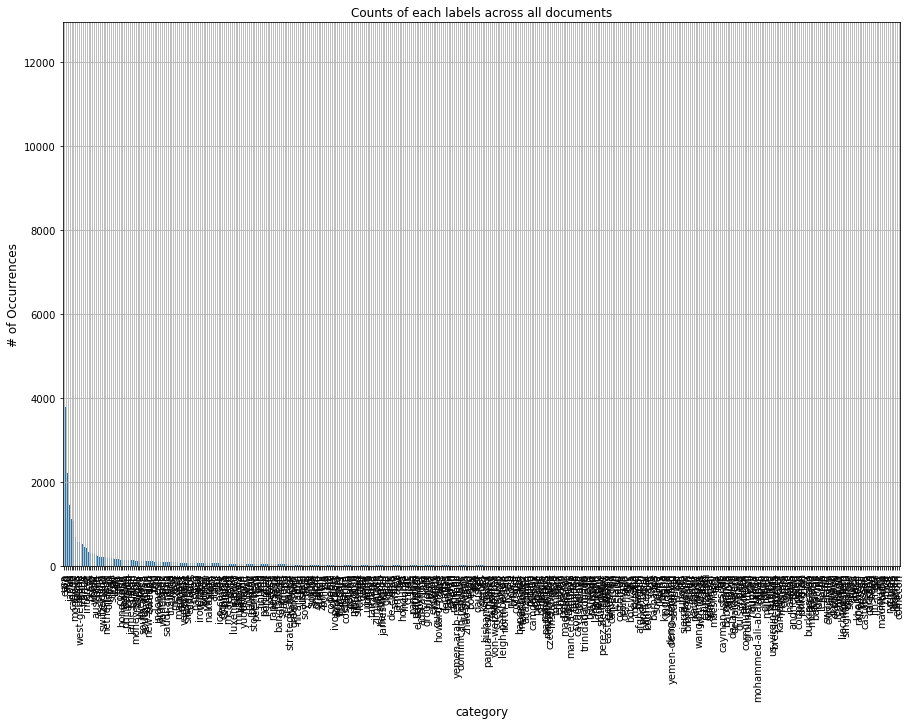

In [31]:
df_occr(df2)

Since a label cannot appear more than once for a document; the plot above shows the labels aren't evenly distributed across all documents. This means some labels are sparse than others, which will cause a bias to the dominant labels.

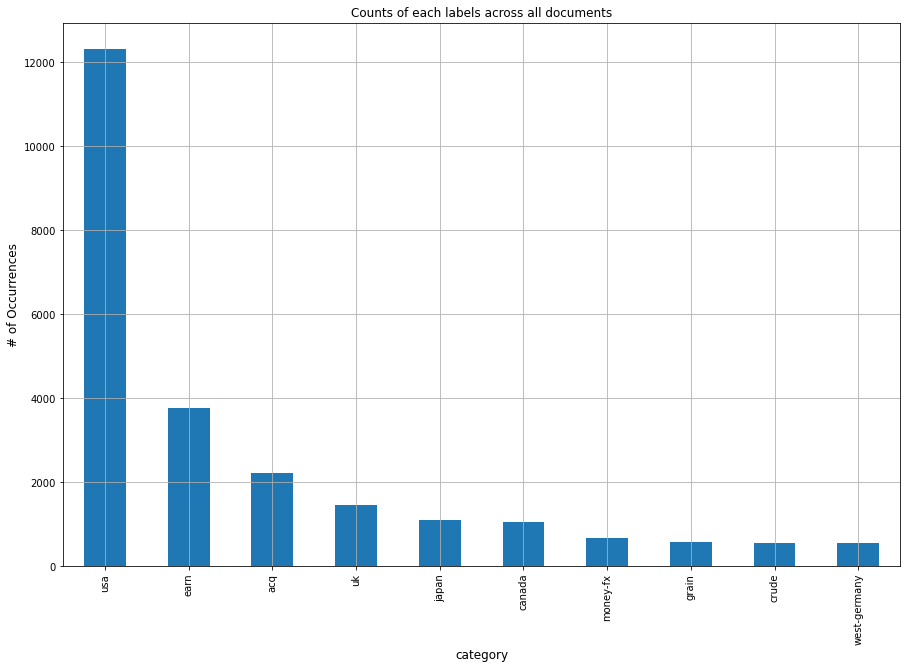

In [32]:
df_occr(df2, 10)

Zooming into the plot ...

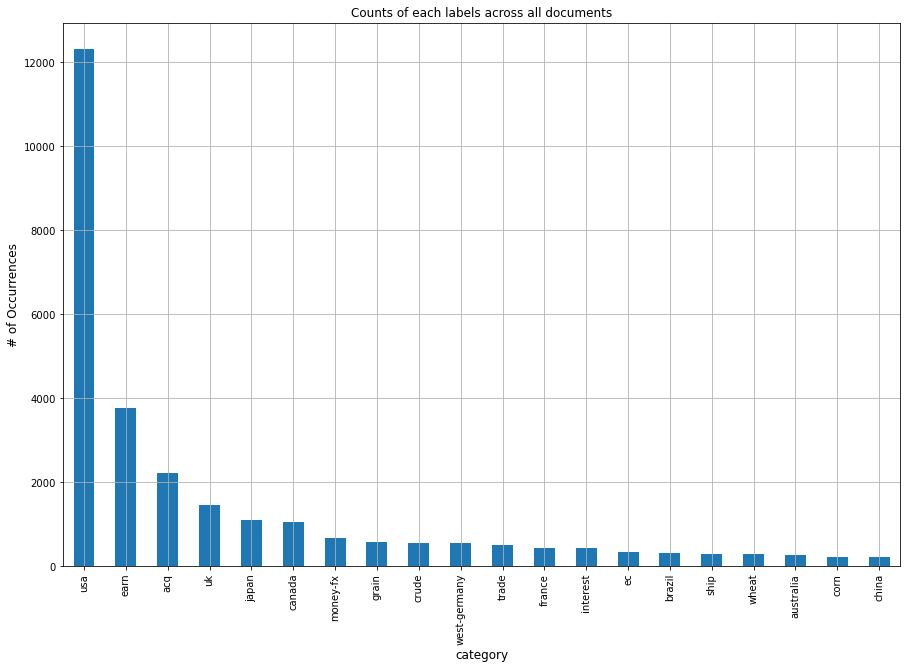

In [33]:
df_occr(df2, 20)

Zooming in more ...

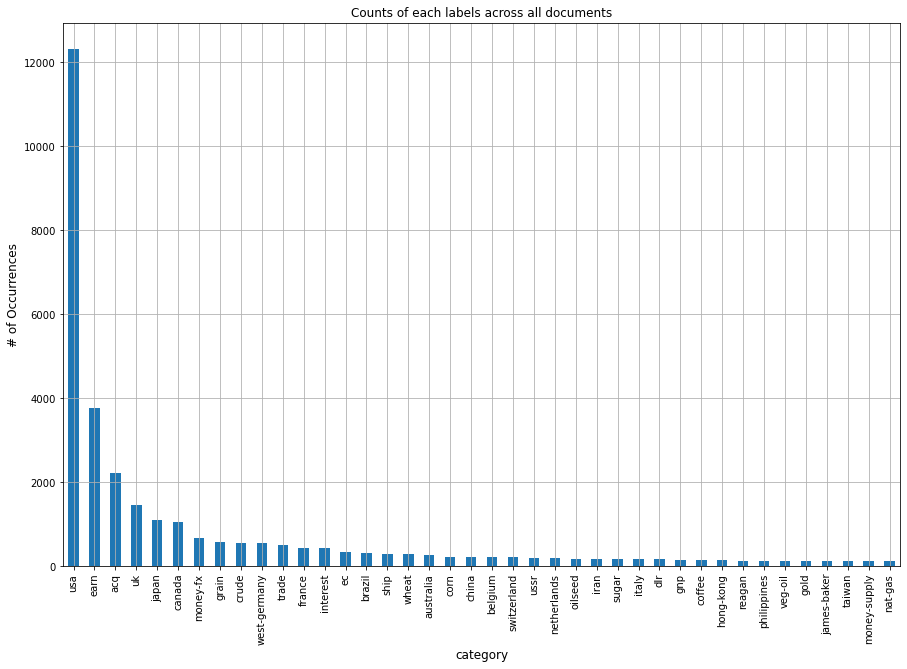

In [34]:
df_occr(df2, 40)

Zooming in even more .....

So we get the point. A way to solve this is making the classes somewhat evenly distributed by combining classes. This is an art, not a science and will depend on objectives and how effective one needs the predicitive abilities to be from the data. Combining labels maybe also require some domain knowledge to achieve a grouping that makes sense. For the purpose of this work, we will just exemplify this approach to see it's effectiveness.  

In [35]:
df2

,labels,counts
2,usa,12322
20,earn,3776
21,acq,2210
29,uk,1451
64,japan,1104
...,...,...
379,rupiah,1
378,prawiro,1
376,guinea,1
279,euratom,1


In [36]:
new_labels = df2.head().labels.values.tolist()
new_labels

['usa', 'earn', 'acq', 'uk', 'japan']

In [37]:
new_labels2 = df2.labels.values.tolist()
new_labels2

['usa',
 'earn',
 'acq',
 'uk',
 'japan',
 'canada',
 'money-fx',
 'grain',
 'crude',
 'west-germany',
 'trade',
 'france',
 'interest',
 'ec',
 'brazil',
 'ship',
 'wheat',
 'australia',
 'corn',
 'china',
 'belgium',
 'switzerland',
 'ussr',
 'netherlands',
 'oilseed',
 'iran',
 'sugar',
 'italy',
 'dlr',
 'gnp',
 'coffee',
 'hong-kong',
 'reagan',
 'philippines',
 'veg-oil',
 'gold',
 'james-baker',
 'taiwan',
 'money-supply',
 'nat-gas',
 'spain',
 'livestock',
 'south-africa',
 'south-korea',
 'soybean',
 'new-zealand',
 'sweden',
 'imf',
 'bop',
 'cpi',
 'indonesia',
 'argentina',
 'opec',
 'worldbank',
 'iraq',
 'saudi-arabia',
 'india',
 'thailand',
 'nyse',
 'mexico',
 'gatt',
 'malaysia',
 'copper',
 'carcass',
 'venezuela',
 'reserves',
 'singapore',
 'ecuador',
 'jobs',
 'cocoa',
 'nasdaq',
 'rice',
 'iron-steel',
 'volcker',
 'turkey',
 'cotton',
 'yeutter',
 'nakasone',
 'alum',
 'yen',
 'amex',
 'ipi',
 'gas',
 'ico-coffee',
 'denmark',
 'colombia',
 'kuwait',
 'meal-fee

In [38]:
y_train[:7]

[['acq', 'usa'],
 ['sugar', 'mauritius', 'uk'],
 ['acq', 'usa'],
 ['usa'],
 ['usa'],
 ['usa'],
 ['grain', 'orange', 'sugar', 'china']]

In [39]:
# Created a function that will do this merge or groupings
# number of labels ranges from 0 to 90
# label type is either y_train or y_test

def label_merge(label_type, number_of_label=1, ):
    """
     This function allows one merge or group labels

     number_of_positive_labels: where positve label is 1 and all other\
     labels are merged/grouped into the negative label 0. original number\
     of labels ranging from 0 to 90.
     
     label_type: this either the y_test (labels of the test set) or \
     y_train (labels of the train set)
     
     """
    
    new_labels = df2.head(number_of_label).labels.values.tolist()
    for ele in (label_type):
        for i, x in enumerate (ele):
            if x in new_labels:
                continue
            else: 
                ele[i] = 'merged'

In [40]:
#applying the merge function to the train and test labels
label_merge(y_train, 3)
y_train[:5]

[['acq', 'usa'],
 ['merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['usa']]

In [41]:
y_train[:11]

[['acq', 'usa'],
 ['merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['usa'],
 ['usa'],
 ['merged', 'merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['merged', 'merged', 'merged', 'merged'],
 ['earn', 'usa']]

In [42]:
import itertools
import collections

def df_occr2(labels):
    
    merged_labels = list(itertools.chain(*labels)) #flattening list of list
    
    #creating a dataframe sorted by the number of counts of each labels in the documents
    counter=collections.Counter(merged_labels)
        
    df = pd.DataFrame(zip(counter.keys(), counter.values()), columns = ['labels', 'counts'])
    df2 = df.sort_values(by='counts', ascending=False)
    
    #df3= df2.head(limit)
    df2.plot(x='labels', y='counts', kind='bar', legend=False, grid=True, figsize=(15, 10))
    plt.title("Counts of each labels across all documents")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('category', fontsize=12)

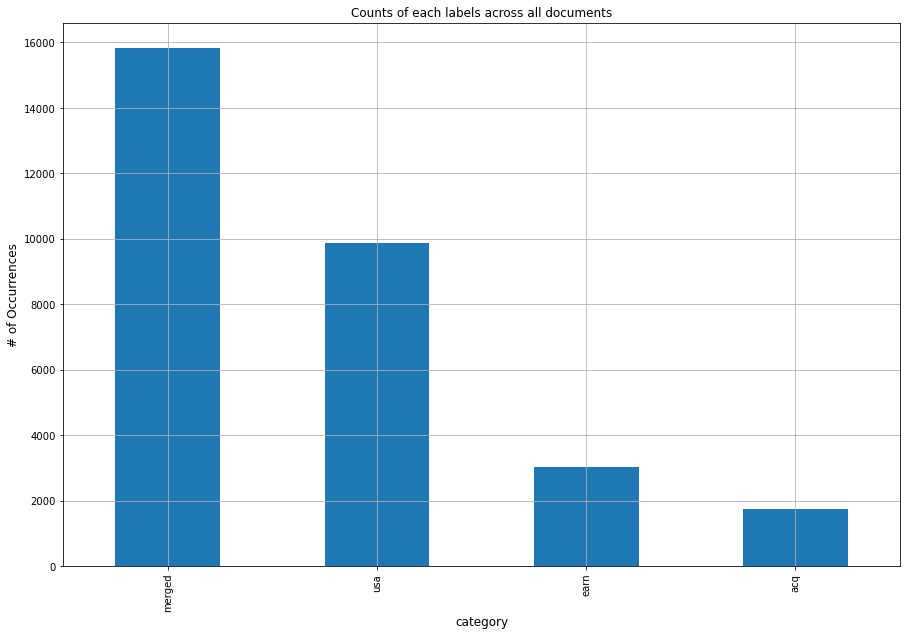

In [43]:
df_occr2(y_train)

In [44]:
label_merge(y_test, 3)

In [45]:
#transform multilabel labels
#mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

In [46]:
classifier = classifier.fit(vectorized_train_docu, train_labels)

In [47]:
pred_eval(classifier, vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

Cross-validation scores: [0.82864883 0.82797155 0.82356925 0.83068066 0.81916695]
Cross-validation accuracy: 0.8260 (+/- 0.0083)

Micro-average quality numbers
Precision: 0.9354, Recall: 0.9275, F1-measure: 0.9314

Macro-average quality numbers
Precision: 0.9090, Recall: 0.9174, F1-measure: 0.9126


In [48]:
new_labels = df2.head(3).labels.values.tolist()
new_labels

['usa', 'earn', 'acq']

In [49]:
def label_merge_top(label_type,):
    """
     This function allows one merge or group labels

     number_of_positive_labels: where positve label is 1 and all other\
     labels are merged/grouped into the negative label 0. original number\
     of labels ranging from 0 to 90.
     
     label_type: this either the y_test (labels of the test set) or \
     y_train (labels of the train set)
     
     """
    
    new_labels = df2.head(3).labels.values.tolist()
    for ele in (label_type):
        for i, x in enumerate (ele):
            if x in new_labels:
                ele[i] = 'top_three_label'
                #continue
            else: 
                ele[i] = 'not_a_top_three_label'

In [50]:
label_merge_top(y_train)
label_merge_top(y_test)

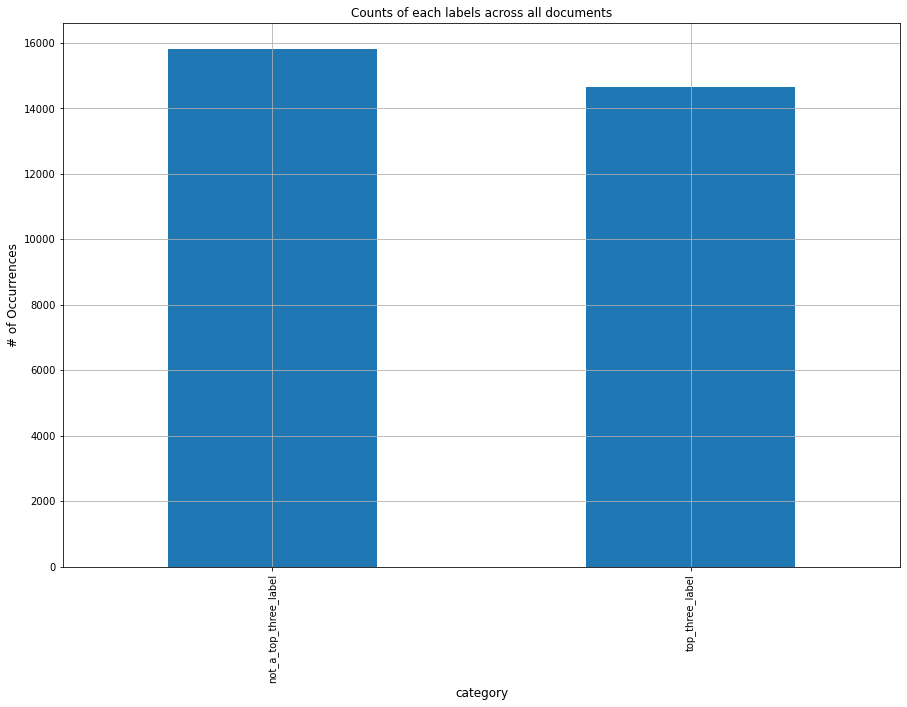

In [51]:
df_occr2(y_train)

In [52]:
#transform multilabel labels
#mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

classifier = classifier.fit(vectorized_train_docu, train_labels)

pred_eval(classifier, vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

Cross-validation scores: [0.87233322 0.87673552 0.88046055 0.8730105  0.8730105 ]
Cross-validation accuracy: 0.8751 (+/- 0.0062)

Micro-average quality numbers
Precision: 0.9588, Recall: 0.9299, F1-measure: 0.9441

Macro-average quality numbers
Precision: 0.9575, Recall: 0.9266, F1-measure: 0.9418


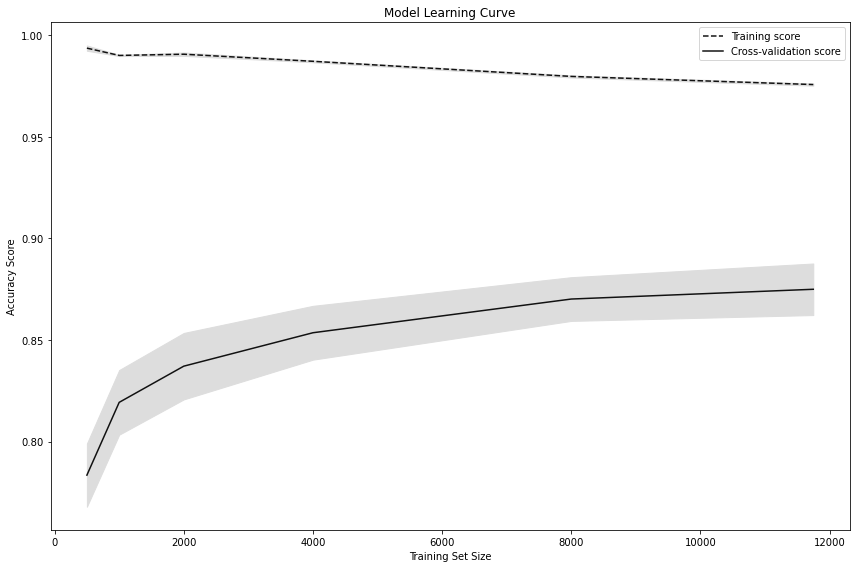

In [53]:
# Create CV training and test scores for various training set sizes

#@ credit goes to 

from sklearn.model_selection import learning_curve
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
train_sizes, train_scores, valid_scores = learning_curve(classifier, vectorized_train_docu, train_labels, cv=20, 
                                                                     scoring='accuracy', n_jobs=-1,
                                                                     train_sizes=[500, 1000, 2000, 4000, 8000, 11747])

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, valid_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="#DDDDDD")

# Create plot
plt.title("Model Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The learning curve above shows how much improvement a model makes with an increase in the training set size. We need to see in the plot that the cross-validated solid line gets close to the training score dashed line as much as possible.

The training dataset we have here is shy of about 12000 examples, after train-test split and treatment of null documents, which is small in this case. So, care was taken not to unnecessarily drop data points without thoroughly understanding and investigating its effects.

The learning curve above shows our model performs better with increasingly additional examples, so dropping data points is not advisable. 


In [54]:
classifier.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__loss', 'estimator__max_iter', 'estimator__multi_class', 'estimator__penalty', 'estimator__random_state', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

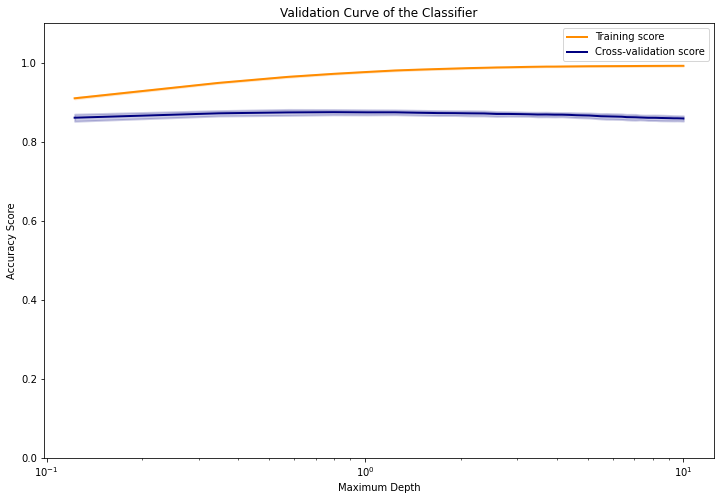

In [55]:
#@ credit goes to https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html\
          #sklearn.model_selection.validation_curve


from sklearn.model_selection import validation_curve
np.random.seed(0)

#indices = y.shape[0]
#np.random.shuffle(indices)

X, y = vectorized_train_docu, train_labels
param_range = np.linspace(-1, 10, num=50)
train_scores, valid_scores = validation_curve(classifier, X, y, param_name='estimator__C', param_range=param_range, cv=5,
                                              scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

plt.title("Validation Curve of the Classifier")
plt.xlabel(r"Maximum Depth")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
 color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
 train_scores_mean + train_scores_std, alpha=0.2,
 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
 color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
 valid_scores_mean + valid_scores_std, alpha=0.2,
 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()